# Data-based Systems Results analysis

In this notebook we are going to analyze the runs of the best data-based system ([d] configuration). Our best system is obtained with the Standard Parsing configuration (Jena + RDFLib + LightRDF) and by using the Lucene Tokenizer and the NLTK Stoplist. In order to see what we are missing with respect to the data-based system developed by ACORDAR we are going to do the following analysis:
- Failure Analysis 
- Impact of empty datasets
- Impact of partial datasets
- Difference between my runs and acordar ones in order to see ranks and scores differences

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

dirname = os.path.dirname(__name__)

## 1. Failure Analysis

Let's do a failure analysis in order to have a global vision of the performances of the 2 systems.

In [2]:
title_pad = 20
title_dim = 'xx-large'
xy_pad = 12
xy_label_dim = 'large'
figure_size = (20, 10)

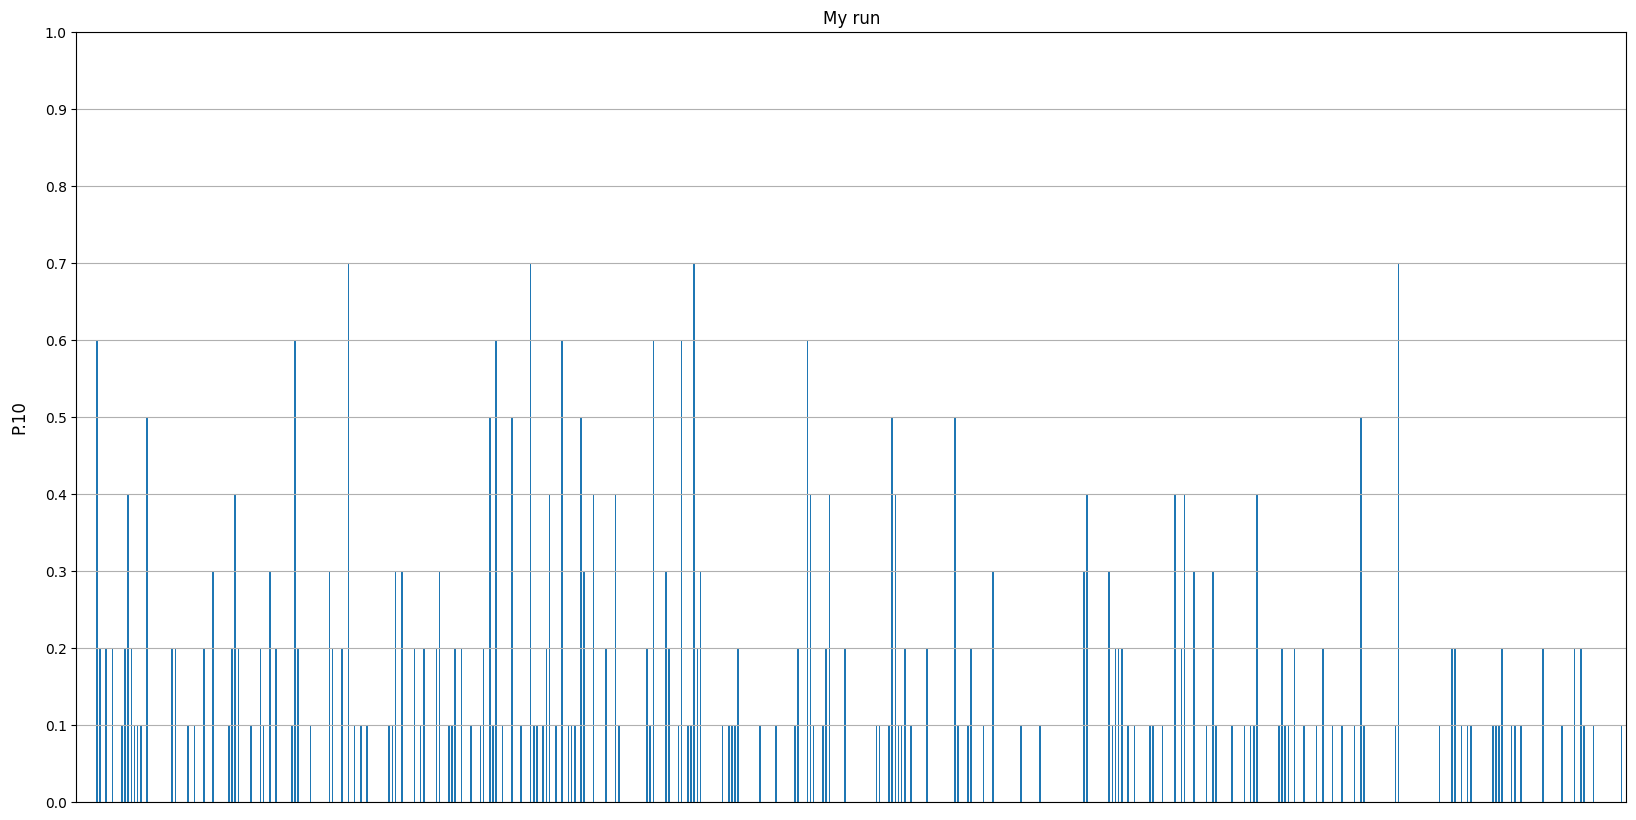

In [3]:
filecsv_myscores = os.path.join(dirname, "../../files/run/ARDFS/scores/standard_Stop/BM25Boost[d].csv")
my_df = pd.read_csv(filecsv_myscores, sep = ',')

my_df.drop(my_df.tail(1).index,inplace=True)

plt.rcParams["figure.figsize"] = figure_size

#Bar plot
my_df.plot(kind='bar',x='query_id',y='score',legend=None)
axes = plt.gca()
axes.yaxis.grid()
axes.get_xaxis().set_visible(False)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('P.10', labelpad=xy_pad, fontsize=xy_label_dim)
plt.title("My run")
plt.show()
     


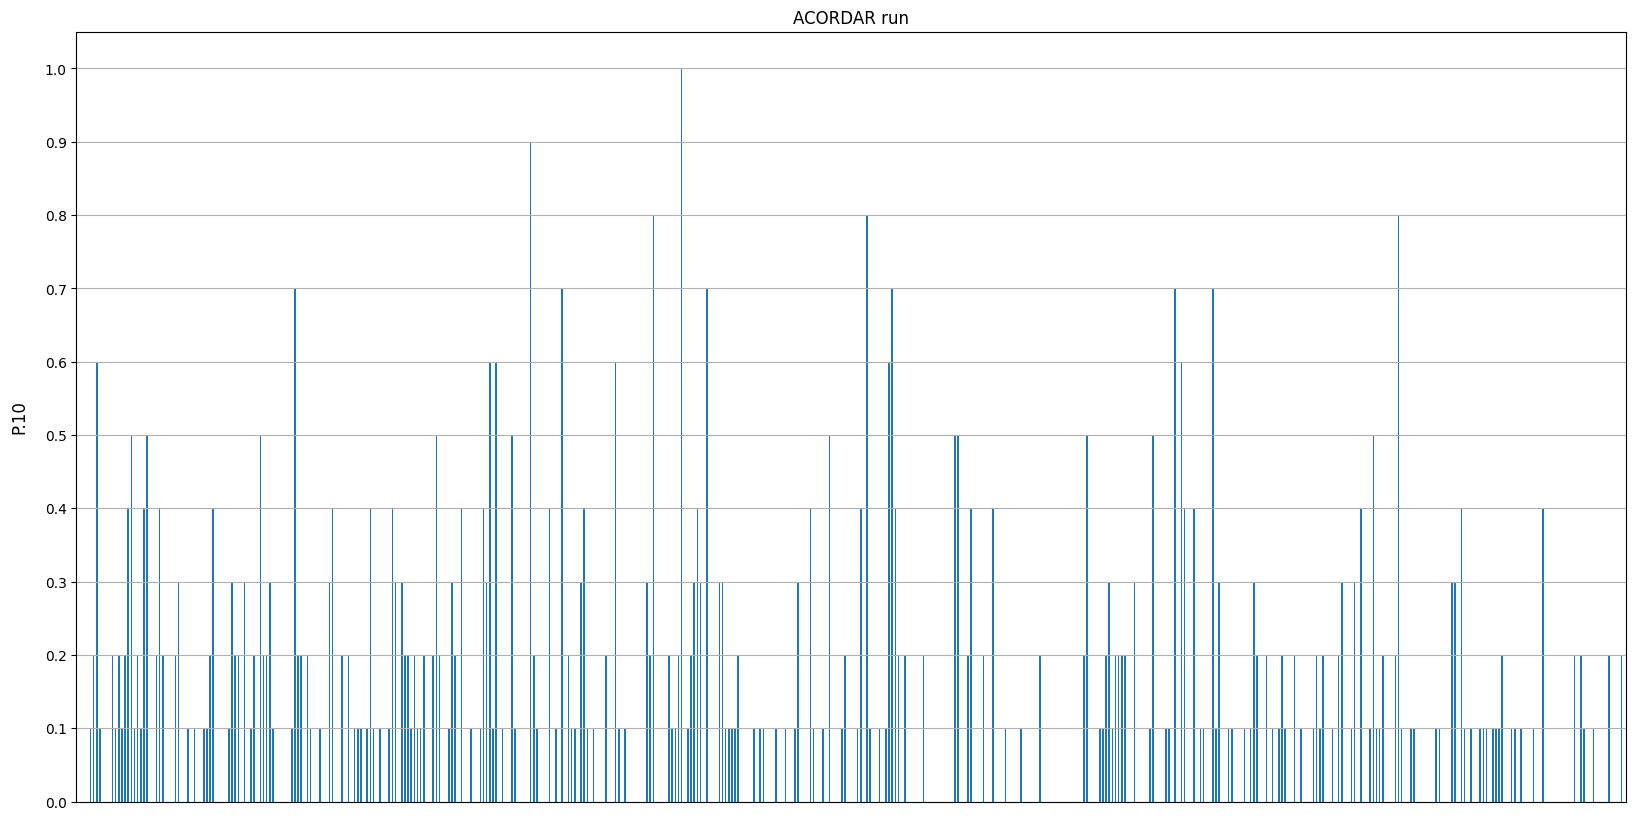

In [4]:
filecsv_acordar = os.path.join(dirname, "../../files/run/ACORDAR/scores/BM25F[d].csv")
df_acordar = pd.read_csv(filecsv_acordar, sep = ',')

df_acordar.drop(df_acordar.tail(1).index,inplace=True)

plt.rcParams["figure.figsize"] = figure_size

#Bar plot
df_acordar.plot(kind='bar',x='query_id',y='score',legend=None)
axes = plt.gca()
axes.yaxis.grid()
axes.get_xaxis().set_visible(False)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('P.10', labelpad=xy_pad, fontsize=xy_label_dim)
plt.title("ACORDAR run")

plt.show()
     


## 2. Paired T-Test

From the above charts we can see that the two runs have different trends. We do a Paired T-Test in order to see if the two runs are effectively different. 


In [5]:
import scipy.stats as stats

acordar_scores = df_acordar["score"]
my_scores = my_df["score"]

stats.ttest_rel(acordar_scores, my_scores)

TtestResult(statistic=6.931039947968787, pvalue=1.3162636656260437e-11, df=492)

the p-value is much lower than 0.05 so we accept the hypothesis that the two runs are different.

## 3. Impact of Empty Datasets

Since during the download and parsing phases we are losing some files because of download and parsing errors, now we are going to consider the impact of the empty datasets (datasets without a parsed file). 

In [6]:
#create two maps query_id -> score for my scores and acordar scores

acordar_scores_map = dict()
my_scores_map = dict()

queries_ids = my_df["query_id"].tolist()
for i in range(len(queries_ids)):
    acordar_scores_map[int(queries_ids[i])] = acordar_scores[i]
    my_scores_map[int(queries_ids[i])] = my_scores[i]


In [7]:
#let's build a simple query -> query_text map

queries_file = open(os.path.join(dirname, "../../files/all_queries.txt"), "r")
queries_text = dict()

while True:
    line = queries_file.readline()

    if not line:
        break

    split = line.split("\t")
    query_id = int(split[0])
    text = split[1].strip()

    queries_text[query_id] = text
queries_file.close()


In [8]:
#build the qrels map. query_id -> dataset_id -> relevance

qrels = dict()

qrels_file = open(os.path.join(dirname, "../../files/qrels.txt"), "r")

while True:
    line = qrels_file.readline()

    if not line:
        break

    split = line.split("\t")
    query_id = int(split[0])
    dataset_id = int(split[2])
    rel = int(split[3])

    if query_id not in qrels:
        qrels[query_id] = dict()

    qrels[query_id][dataset_id] = rel
qrels_file.close()

In [9]:
#load my ranks and acordar ones for all the queries in order to see a diff

def generate_ranks(run_file):
    ranks = dict()
    ranks_with_rel = dict()

    while True:
        line = run_file.readline()

        if not line:
            break

        split = line.split("\t")
        query_id = int(split[0])
        dataset_id = int(split[2])

        if query_id not in ranks.keys():
            ranks[query_id] = list()
            ranks_with_rel[query_id] = list()

        #recover the relevance scores
        rel = None
        if query_id in qrels.keys():
            if dataset_id in qrels[query_id].keys():
                rel = qrels[query_id][dataset_id]
        
        ranks_with_rel[query_id].append((dataset_id, rel))
        ranks[query_id].append(dataset_id) 
    
    return ranks, ranks_with_rel

acordar_run = open(os.path.join(dirname, "../../files/run/ACORDAR/BM25F[d].txt"), "r")
my_run = open(os.path.join(dirname, "../../files/run/ARDFS/standard_Stop/BM25Boost[d].txt"), "r")

acordar_ranks,acordar_ranks_with_rel = generate_ranks(acordar_run)
my_ranks, my_ranks_with_rel = generate_ranks(my_run)

acordar_run.close()
my_run.close()

In [21]:
#open the empty datasets json list file
empty_datasets_file = open(os.path.join(dirname, "../../files/datasets_lists/standard/empty_datasets_standard.json"), "r")
empty_datasets_set = json.load(empty_datasets_file)
empty_datasets_set = set(empty_datasets_set)
empty_datasets_file.close()

#open the full datasets json list file
full_datasets_file = open(os.path.join(dirname, "../../files/datasets_lists/standard/full_datasets_standard.json"), "r")
full_datasets_set = json.load(full_datasets_file)
full_datasets_set = set(full_datasets_set)
full_datasets_file.close()

#open the partial datasets json list file
partial_datasets_file = open(os.path.join(dirname, "../../files/datasets_lists/standard/partial_datasets_standard.json"), "r")
partial_datasets_set = json.load(partial_datasets_file)
partial_datasets_set = set(partial_datasets_set)
partial_datasets_file.close()

In [23]:
#we have to filter only the empty datasets that are relevant for some queries

qrels_file = open(os.path.join(dirname, "../../files/qrels.txt"), "r")
query_empty_relevant_datasets = dict()
query_partial_relevant_datasets = dict()
query_full_relevant_datasets = dict()

while True:
    line = qrels_file.readline()

    if not line:
        break

    split = line.split("\t")
    query_id = int(split[0])
    dataset_id = int(split[2])
    rel = int(split[3])

    if rel > 0 and dataset_id in empty_datasets_set:
        if query_id not in query_empty_relevant_datasets:
             query_empty_relevant_datasets[query_id] = set()
    
        query_empty_relevant_datasets[query_id].add(dataset_id)

    if rel > 0 and dataset_id in partial_datasets_set:   
        if query_id not in query_partial_relevant_datasets:
             query_partial_relevant_datasets[query_id] = set()
            
        query_partial_relevant_datasets[query_id].add(dataset_id)

    if rel > 0 and dataset_id in full_datasets_set:   
        if query_id not in query_full_relevant_datasets:
            query_full_relevant_datasets[query_id] = set()

        query_full_relevant_datasets[query_id].add(dataset_id)

qrels_file.close()
    

In [24]:
#generate a map query_id -> score acordar, my score, my rank, acordar rank, empty datasets in acordar rank

queries_score_ranks_empty = dict()

for query in queries_text.keys():
    acordar_rank = set(acordar_ranks[query])
    my_rank = set(my_ranks[query])

    intersection_empty = set()
    intersection_partial = set()
    intersection_full = set()
    
    if query in query_empty_relevant_datasets.keys():
        intersection_empty = query_empty_relevant_datasets[query].intersection(acordar_rank)
    
    if query in query_partial_relevant_datasets.keys():
        intersection_partial = query_partial_relevant_datasets[query].intersection(acordar_rank)

    if query in query_full_relevant_datasets.keys():
        intersection_full = query_full_relevant_datasets[query].intersection(acordar_rank)
        
    common_datasets = acordar_rank.intersection(my_rank)

    if query not in queries_score_ranks_empty.keys():
        queries_score_ranks_empty[query] = dict()

    queries_score_ranks_empty[query]["acordar_score"] = acordar_scores_map[query]
    queries_score_ranks_empty[query]["my_score"] = my_scores_map[query]
    queries_score_ranks_empty[query]["acordar_rank"] = acordar_ranks[query]
    queries_score_ranks_empty[query]["acordar_rank_with_rel"] = acordar_ranks_with_rel[query]
    queries_score_ranks_empty[query]["my_rank"] = my_ranks[query]
    queries_score_ranks_empty[query]["my_rank_with_rel"] = my_ranks_with_rel[query]
    queries_score_ranks_empty[query]["empty_datasets"] = intersection_empty
    queries_score_ranks_empty[query]["partial_datasets"] = intersection_partial
    queries_score_ranks_empty[query]["full_datasets"] = intersection_full
    queries_score_ranks_empty[query]["common_datasets"] = common_datasets
    

In [26]:
#print the details about queries where acordar returns empty datasets

i = 0 
for query in queries_score_ranks_empty.keys():
    if len(queries_score_ranks_empty[query]["empty_datasets"]) > 0:
        print(f"{query} {queries_text[query]}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_score']} M: {queries_score_ranks_empty[query]['my_score']}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_rank_with_rel']}")
        print(f"M: {queries_score_ranks_empty[query]['my_rank_with_rel']}")
        print(f"Relevant Empty datasets: {queries_score_ranks_empty[query]['empty_datasets']}")
        print(f"Relevant Partial datasets: {queries_score_ranks_empty[query]['partial_datasets']}")
        print(f"Relevant Full datasets: {queries_score_ranks_empty[query]['full_datasets']}")
        print(f"Common datasets: {queries_score_ranks_empty[query]['common_datasets']}")
        print()
        i+=1
print(i)

22 MCI
A: 0.2 M: 0.4
A: [(2690, 1), (6475, 1), (10260, 0), (10527, 0), (30519, 0), (43248, 0), (3575, 0), (63195, 0), (9464, 0), (11888, 0)]
M: [(6496, 1), (76108, 1), (4130, 1), (3331, 1), (49277, None), (7994, None), (74810, None), (3436, None), (6800, None), (7140, None)]
Relevant Empty datasets: {2690}
Relevant Partial datasets: set()
Relevant Full datasets: {6475}
Common datasets: set()

26 Information Retrieval Systems
A: 0.5 M: 0.0
A: [(14921, None), (13577, None), (13349, 1), (14509, 2), (10280, 1), (61802, 1), (4989, 1), (8235, None), (76472, None), (71080, None)]
M: [(13142, None), (7991, None), (55395, None), (71080, None), (76347, None), (7353, None), (3313, None), (8330, None), (8235, None), (8836, None)]
Relevant Empty datasets: {13349, 14509}
Relevant Partial datasets: set()
Relevant Full datasets: {10280, 61802, 4989}
Common datasets: {71080, 8235}

28 Surrogate Motherhood
A: 0.1 M: 0.0
A: [(24355, 1), (10728, 0), (2387, 0), (13284, 0), (14417, 0), (44159, 0), (44738, 0

In order to see if the empty datasets have an impact in the system performances we follow the following idea: if empty datasets not returned in my runs can improve the P10 and reach the ACORDAR P10 for that query, I substitute the P10 score for that query with the ACORDAR one. Then I calculate the new total P10 for the query, in order to see if he have an improvement.

In [15]:
my_scores_map_new = my_scores_map.copy()

for query in queries_score_ranks_empty.keys():
    if queries_score_ranks_empty[query]["my_score"] + (len(queries_score_ranks_empty[query]["empty_datasets"]) / 10) == queries_score_ranks_empty[query]["acordar_score"]:
        my_scores_map_new[query] = queries_score_ranks_empty[query]["acordar_score"]

score_new = 0
score_old = 0
score_acordar = 0
for query in my_scores_map_new.keys():
    score_new += my_scores_map_new[query]
    score_old += my_scores_map[query]
    score_acordar += acordar_scores_map[query]

print(f"Old P10: {score_old/len(my_scores_map.keys())}") 
print(f"New P10: {score_new/len(my_scores_map.keys())}") 
print(f"ACORDAR P10: {score_acordar/len(my_scores_map.keys())}") 

Old P10: 0.07687626774847889
New P10: 0.0851926977687629
ACORDAR P10: 0.11419878296146073


from this simple analysis we can see that the increment of the P@10 is of 0.01 points, so the empty datasets are not affecting the results too much

## Partial Datasets

In [16]:
#print details about queries where acordar not returns empty datasets

i=0
for query in queries_score_ranks_empty.keys():
    if len(queries_score_ranks_empty[query]["empty_datasets"]) == 0:
        print(f"{query} {queries_text[query]}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_score']} M: {queries_score_ranks_empty[query]['my_score']}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_rank_with_rel']}")
        print(f"M: {queries_score_ranks_empty[query]['my_rank_with_rel']}")
        print(f"Empty datasets: {queries_score_ranks_empty[query]['empty_datasets']}")
        print(f"Common datasets: {queries_score_ranks_empty[query]['common_datasets']}")
        print()
        i+=1
print(i)

1 Antitrust Cases Pending
A: 0.0 M: 0.0
A: [(53737, 0), (12509, 0), (12398, 0), (71080, None), (75371, 0), (10239, None), (7092, None), (61382, None), (76923, None), (79280, None)]
M: [(12398, 0), (12509, 0), (52100, None), (42979, 0), (10073, None), (71080, None), (10239, None), (9375, None), (2517, None), (2293, None)]
Empty datasets: set()
Common datasets: {71080, 12509, 12398, 10239}

2 Acquisitions
A: 0.4 M: 0.4
A: [(49347, 1), (2445, 1), (50677, 1), (50686, None), (2330, None), (2517, None), (2614, 1), (50690, None), (2293, None), (50718, None)]
M: [(50759, 1), (50714, 1), (50752, 1), (50765, 1), (50707, None), (50757, None), (50709, None), (50715, None), (50737, None), (50787, None)]
Empty datasets: set()
Common datasets: set()

3 Debt Rescheduling
A: 0.0 M: 0.0
A: [(8872, 0), (55432, 0), (2175, 0), (26426, 0), (15636, None), (14196, None), (53635, None), (53643, None), (53653, None), (28391, None)]
M: [(55432, 0), (8872, 0), (11484, None), (31653, None), (74539, None), (14196, 

# utils

In [17]:
# what if we increment the P10 score with a percentage point for every empty datasets not returned?

new_scores = []
for i in range(len(ndcg) - 1):
    if ndcg[i] == 0 and ndcg_acordar[i]!=0:
        if 
        new_ndcg.append(ndcg_acordar[i])
    else:
        new_ndcg.append(ndcg[i])

new_tot_ndcg = 0
old_tot_ndcg = 0 
tot_ndcg_acordar = 0 
for i in range(len(new_ndcg)):
    new_tot_ndcg += new_ndcg[i]
    old_tot_ndcg += ndcg[i]
    tot_ndcg_acordar += ndcg_acordar[i]
print(f"New ndcg@5 {new_tot_ndcg / len(new_ndcg)}")
print(f"Old ndcg@5 {old_tot_ndcg / len(new_ndcg)}")
print(f"Acordar ndcg@5 {tot_ndcg_acordar / len(ndcg_acordar)}")



SyntaxError: invalid syntax (1921390419.py, line 6)

In [ ]:
#analyze in which queries we have a null score and ACORDAR not. We build a map (problem queries)

queries_ids = df["query_id"].tolist()

queries_score = dict()
problem_queries = dict()

for i in range(len(my_scores)):
    if my_scores[i] == 0 and acordar_scores[i]!=0:
        print(f"Problem in query {queries_ids[i]}, ACORDAR score: {acordar_scores[i]}")
        query_id = int(queries_ids[i])
        if query_id not in problem_queries:
            problem_queries[query_id] = dict()
        problem_queries[query_id]["acordar_score"] = acordar_scores[i]
        problem_queries[query_id]["my_score"] = my_scores[i]
    queries_score[query_id] = my_scores[i]
print(f"Problem queries:"len(problem_queries))

In [ ]:
for query in problem_queries:
    acordar_rank = set(acordar_ranks[query])
    my_rank = set(my_ranks[query])
    intersection = set()
    if query in query_empty_relevant_datasets.keys():
        intersection = query_empty_relevant_datasets[query].intersection(acordar_rank)
        
    common_datasets = acordar_rank.intersection(my_rank)

    problem_queries[query]["acordar_rank"] = acordar_ranks[query]
    problem_queries[query]["acordar_rank_with_rel"] = acordar_ranks_with_rel[query]
    problem_queries[query]["my_rank"] = my_ranks[query]
    problem_queries[query]["my_rank_with_rel"] = my_ranks_with_rel[query]
    problem_queries[query]["empty_datasets"] = intersection
    problem_queries[query]["common_datasets"] = common_datasets
    

In [ ]:
for query in problem_queries:
    acordar_rank = set(acordar_ranks[query])
    my_rank = set(my_ranks[query])
    intersection = set()
    if query in query_empty_relevant_datasets.keys():
        intersection = query_empty_relevant_datasets[query].intersection(acordar_rank)
        
    common_datasets = acordar_rank.intersection(my_rank)

    problem_queries[query]["acordar_rank"] = acordar_ranks[query]
    problem_queries[query]["acordar_rank_with_rel"] = acordar_ranks_with_rel[query]
    problem_queries[query]["my_rank"] = my_ranks[query]
    problem_queries[query]["my_rank_with_rel"] = my_ranks_with_rel[query]
    problem_queries[query]["empty_datasets"] = intersection
    problem_queries[query]["common_datasets"] = common_datasets
    

In [ ]:
for query in problem_queries.keys():
    if problem_queries[query]["my_score"] + (len(problem_queries[query]["empty_datasets"]) / 10) == problem_queries[query]["acordar_score"]:
        queries_score[query] = problem_queries[query]["acordar_score"]

p10 = 0
for query in queries_score.keys():
    p10 += queries_score[query]

print(f"New P10: {p10/len(queries_score)}") 